In [1]:
import tensorflow as tf
import keras
from draw_candle_image import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ta.trend
from ta import add_all_ta_features
from ta.utils import dropna
import ta
import ta.momentum
import json
from common_train_utils import *
from functools import partial
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import pathlib
import shutil
import tempfile
import tensorflow_docs.modeling
from model_code import *
import os

In [2]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [3]:
print(logdir)

C:\Users\ADMIN\AppData\Local\Temp\tmp94yuv9av\tensorboard_logs


In [4]:
dataset_folder = "./dataset/vn30_dataset_0_2_3_2012_2024_test_2023_2024"

In [5]:
config = read_config(dataset_folder)
candle_type_and_directory_save: dict = config["candle_type_and_directory_save"]
previous_days = config["previous_days"]
next_days = config["next_days"]
days_result = config["days_result"]

In [6]:
dataset_test = load_dataset_of_each_type_and_combine(f"{dataset_folder}/test", candle_type_and_directory_save)
total_data_test = len(dataset_test)

folder: bullish_engulfing, 		 total: 10 images
folder: bearish_engulfing, 		 total: 11 images
folder: star_doji, 		 total: 0 images
folder: dragonfly_doji, 		 total: 0 images
folder: gravestone_doji, 		 total: 0 images
folder: morning_star, 		 total: 13 images
folder: evening_star, 		 total: 0 images
folder: hammer, 		 total: 13 images
folder: inverted_hammer, 		 total: 15 images
folder: harami_down, 		 total: 30 images
folder: harami_up, 		 total: 40 images
folder: tweezer_top, 		 total: 0 images
folder: tweezer_bottom, 		 total: 6 images
folder: marubozu, 		 total: 19 images
folder: spin, 		 total: 7 images
folder: next_3_day_up, 		 total: 41 images
folder: next_3_day_down, 		 total: 31 images


In [7]:
dataset_train = load_dataset_of_each_type_and_combine(f"{dataset_folder}/train", candle_type_and_directory_save)
total_data_train = len(dataset_train)

folder: bullish_engulfing, 		 total: 27 images
folder: bearish_engulfing, 		 total: 32 images
folder: star_doji, 		 total: 9 images
folder: dragonfly_doji, 		 total: 9 images
folder: gravestone_doji, 		 total: 14 images
folder: morning_star, 		 total: 39 images
folder: evening_star, 		 total: 54 images
folder: hammer, 		 total: 46 images
folder: inverted_hammer, 		 total: 71 images
folder: harami_down, 		 total: 170 images
folder: harami_up, 		 total: 164 images
folder: tweezer_top, 		 total: 47 images
folder: tweezer_bottom, 		 total: 35 images
folder: marubozu, 		 total: 124 images
folder: spin, 		 total: 54 images
folder: next_3_day_up, 		 total: 219 images
folder: next_3_day_down, 		 total: 166 images


In [37]:
def split_cnn(image_shape, days_result):
    inputs = keras.layers.Input(shape=image_shape)
        
    # Các lớp CNN để trích xuất đặc trưng từ ảnh
    x = keras.layers.Conv2D(days_result, (3, 3), activation='relu')(inputs)
    x = keras.layers.MaxPooling2D((3, 3))(x)

    a = keras.layers.Permute((3, 1, 2))(x)
    
    flatten = keras.layers.TimeDistributed(keras.layers.Flatten())(a)
    flatten = keras.layers.TimeDistributed(keras.layers.Dense(32))(flatten)
    flatten = keras.layers.TimeDistributed(keras.layers.Dense(32))(flatten)
    lstm_1 = keras.layers.LSTM(64, return_sequences=True)(flatten)
    lstm_1 = keras.layers.TimeDistributed(keras.layers.Dense(2))(lstm_1)
     # Chỉ lấy 3 bước thời gian đầu tiên
    output = keras.layers.Lambda(lambda x: x[:, :days_result, :])(lstm_1)  # Lấy 3 bước đầu
    
    # Xây dựng mô hình
    model = keras.models.Model(inputs=[inputs], outputs=output)
    return model, "split_cnn"

In [38]:
for images_train, labels_train, dates_train in dataset_train.take(1):
    break
image_shape = tuple(images_train.shape)
model, model_name = split_cnn(image_shape, days_result)

In [39]:
batch_size = 64
STEPS_PER_EPOCH = total_data_train // batch_size + 1
name_sub_folder_save_metrics = f"{model_name}_{dataset_folder}"
name_folder_save_metrics = f"sizes/{model_name}_{dataset_folder}"
max_epochs = 1
metric_name = "mean_absolute_error"
metric_object = keras.metrics.MeanAbsoluteError(name=metric_name)
val_loss_metric_to_stop = 0.5699
start_learning_rate = 0.01
shuffle_buffer = 300
number_epochs_to_decrease_lr = 5
number_epochs_to_wait = 10

In [40]:
model_name

'split_cnn'

In [41]:
STEPS_PER_EPOCH

21

In [42]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 287, 287, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 285, 285, 3)    │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 95, 95, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute_1 (Permute)             │ (None, 3, 95, 95)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 3, 9025)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 3, 32)          │       288,832 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 3, 32)          │         1,056 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3, 64)          │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 3, 2)           │           130 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 3, 2)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 314,934 (1.20 MB)

 Trainable params: 314,934 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
(total_data_train, total_data_test)

(1280, 236)

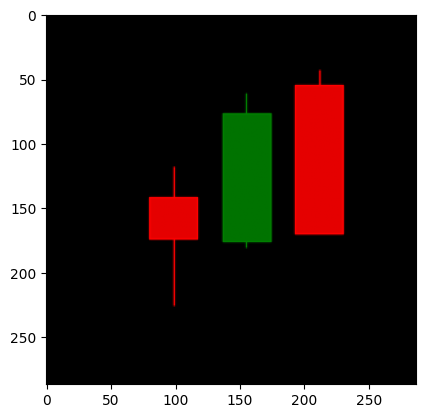

In [44]:
plt.imshow(images_train)

In [45]:
output = model.layers[1](tf.expand_dims(images_train, axis=0))[0]

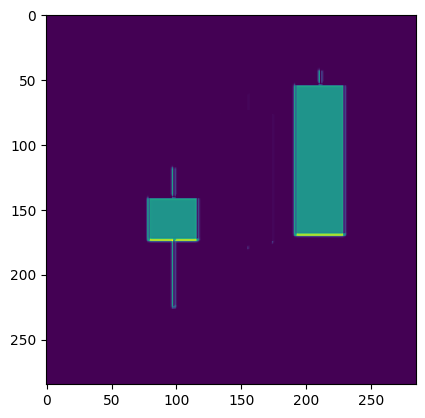

In [46]:
plt.imshow(output[:,:, 0])

In [47]:
dataset_train_1 = dataset_train.shuffle(shuffle_buffer)
dataset_test_1 = dataset_test.shuffle(shuffle_buffer)

dataset_train_2 = dataset_train_1.batch(batch_size)
dataset_test_2 = dataset_test_1.batch(batch_size)

transform_function = partial(get_open_close_prices_percent_of_last_days_result, days_result)
dataset_train_3 = dataset_train_2.map(transform_function)
dataset_test_3 = dataset_test_2.map(transform_function)

In [48]:
(len(dataset_train_3), len(dataset_test_3))

(20, 4)

In [49]:
class StopAtLossValue(keras.callbacks.Callback):
    def __init__(self, target_loss, metric_name):
        super(StopAtLossValue, self).__init__()
        self.target_loss = target_loss
        self.metric_name = metric_name

    def on_epoch_end(self, epoch, logs=None):
        # Lấy giá trị loss từ logs
        current_loss = logs.get(f"val_{self.metric_name}")
        if current_loss is not None and current_loss <= self.target_loss:
            print(f"\nĐạt target loss = {self.target_loss}, dừng training tại epoch {epoch + 1}")
            self.model.stop_training = True

In [50]:
def get_optimizer(start_learning_rate, number_epochs_to_decrease_lr):
    lr_schedule = keras.optimizers.schedules.InverseTimeDecay(
        start_learning_rate,
        decay_steps=STEPS_PER_EPOCH*number_epochs_to_decrease_lr,
        decay_rate=1,
        staircase=False
    )
    
    return keras.optimizers.Adam(lr_schedule)


def get_callbacks(name, metric_name, number_epochs_to_wait):
    return [
        tfdocs.modeling.EpochDots(),
        StopAtLossValue(val_loss_metric_to_stop, metric_name),
        keras.callbacks.EarlyStopping(monitor=f'val_{metric_name}', patience=number_epochs_to_wait),
        keras.callbacks.TensorBoard(logdir/name)
    ]
  
  
model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=get_optimizer(start_learning_rate, number_epochs_to_decrease_lr),
    metrics=[
        metric_object,
    ],
)


In [51]:
is_start_train = input("Start train? (y/n): ").lower()[0] == "y"
if is_start_train:
    history = model.fit(
        dataset_train_3, 
        validation_data=dataset_test_3,
        epochs=max_epochs, 
        steps_per_epoch=STEPS_PER_EPOCH,
        callbacks=get_callbacks(name_folder_save_metrics, metric_name, number_epochs_to_wait)
    )

d:\code\selenium\.venv\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_12']. Received: the structure of inputs=*
  warnings.warn(


20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 1.2368 - mean_absolute_error: 0.7397
Epoch: 0, loss:1.2000,  mean_absolute_error:0.7194,  val_loss:0.7685,  val_mean_absolute_error:0.5888,  
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 226ms/step - loss: 1.2351 - mean_absolute_error: 0.7387 - val_loss: 0.7685 - val_mean_absolute_error: 0.5888


In [52]:
def save_dataset(prefix, dataset_test, model_name):
    prefix_of_folder = prefix
    path_save = f"{dataset_folder}/{prefix_of_folder}_of_{model_name}"
    while os.path.exists(path_save):
        print(f"-- {path_save} already exists")
        prefix_of_folder = prefix_of_folder + "_1"
        path_save = f"{dataset_folder}/{prefix_of_folder}_of_{model_name}"
        print(f"-- Change to {path_save}")
    
    print(f"Save to {path_save}")
    tf.data.Dataset.save(dataset_test, path_save)

In [53]:
def save_model(model: keras.Sequential, model_name):
    path_save = f"{dataset_folder}/model_save/{model_name}.keras"
    while os.path.exists(path_save):
        print(f"-- {path_save} already exists")
        model_name = model_name + "_1"
        path_save = f"{dataset_folder}/model_save/{model_name}.keras"
        print(f"-- Change to {path_save}")
    
    print(f"Save to {path_save}")
    model.save(path_save)
    return os.path.basename(path_save).split('.')[0]

In [54]:
model_name_saved = save_model(model, model_name)

-- ./dataset/vn30_dataset_0_2_3_2012_2024_test_2023_2024/model_save/split_cnn.keras already exists
-- Change to ./dataset/vn30_dataset_0_2_3_2012_2024_test_2023_2024/model_save/split_cnn_1.keras
Save to ./dataset/vn30_dataset_0_2_3_2012_2024_test_2023_2024/model_save/split_cnn_1.keras


In [55]:
size_histories = {}

In [56]:
size_histories[name_sub_folder_save_metrics] = history 

d:\code\selenium\.venv\lib\site-packages\tensorflow_docs\plots\__init__.py:111: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(


(0.0, 2.0)

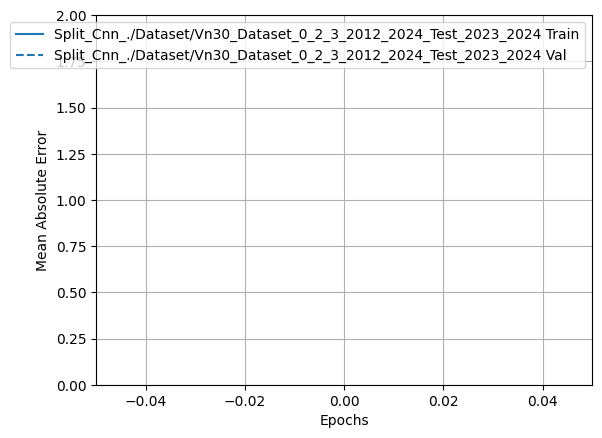

In [57]:
plotter = tfdocs.plots.HistoryPlotter(metric=metric_name, smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0,2])

In [58]:
train_dataset = tf.data.Dataset.load(f'{dataset_folder}/train/next_3_day_up')
test_dataset = tf.data.Dataset.load(f'{dataset_folder}/test/next_3_day_up')

In [59]:
for x_train, y_train, date_train in train_dataset.take(2):
    pass
for x_test, y_test, date_test in test_dataset.take(2):
    pass

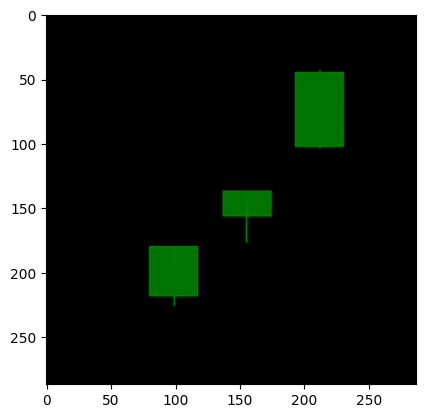

In [60]:
plt.imshow(x_train)

In [61]:
y_train

<tf.Tensor: shape=(6, 4), dtype=float64, numpy=
array([[483.19, 479.93, 485.18, 478.85],
       [488.36, 488.36, 491.01, 485.55],
       [503.74, 495.69, 503.54, 495.45],
       [538.98, 534.73, 508.41, 507.2 ],
       [506.49, 500.2 , 505.9 , 494.59],
       [503.39, 495.63, 489.05, 494.47]])>

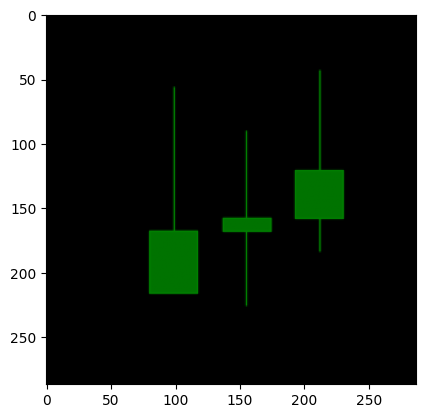

In [62]:
plt.imshow(x_test)

In [63]:
y_test

<tf.Tensor: shape=(6, 4), dtype=float64, numpy=
array([[1076.22, 1060.53, 1065.22, 1060.53],
       [1072.81, 1065.22, 1066.24, 1059.52],
       [1077.45, 1066.24, 1069.86, 1063.68],
       [1076.97, 1069.86, 1075.71, 1066.78],
       [1103.73, 1075.71, 1103.73, 1075.71],
       [1117.23, 1106.89, 1115.72, 1104.98]])>

In [64]:
model_name_saved

'split_cnn_1'

In [65]:
dataset_folder

'./dataset/vn30_dataset_0_2_3_2012_2024_test_2023_2024'